In [97]:
import pandas as pd
import pymc as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

### Functional Analysis of NBA Player Career Trajectory 

$$ y(t) = X\Phi(t) + \epsilon $$
$$ \epsilon \sim \mathcal{N}(0, \Sigma) $$
where $\Phi(t)$ is a functional. Here, we let $X$ be fixed set of covariates (initially)

In [2]:
data = pd.read_csv("data/player_data.csv")

In [50]:
def process_data(df, output_metric, exposure, model, input_metrics):

    agg_dict = {input_metric:"max" for input_metric in input_metrics}
    df = df.sort_values(by=["id","year"])
    df["ft_pct"] = df["ftm"] / df["fta"]
    df["three_pct"] = df["fg3m"] / df["fg3a"]
    df["two_pct"] = df["fg2m"] / df["fg2a"]
    X = df[input_metrics + ["id"]].groupby("id").agg(agg_dict).reset_index()[input_metrics]
    metric_df = df[[output_metric, "id", "age"]]
    exposure_df = df[["id", "age", exposure]]
    metric_df  = metric_df.pivot(columns="age",values=output_metric,index="id")
    if model == "poisson":
        offset = np.log(exposure_df.pivot(columns="age", values=exposure,index="id").fillna(1).to_numpy())
        return offset, metric_df.to_numpy(), X
    elif model == "binomial":
        trials = exposure_df.pivot(columns="age", index="id", values=exposure).to_numpy()
        return trials, metric_df.to_numpy(), X
    elif model == "gaussian":
        variance_scale = np.sqrt(exposure_df.pivot(columns="age", index="id", values=exposure).to_numpy())
        return variance_scale, metric_df.to_numpy(), X
    return ValueError


In [75]:
exposure, Y, X = process_data(data, "obpm", "median_minutes_per_game", "gaussian", ["position_group","median_minutes_per_game"])

Only using position group here, just to keep it simple. Just something that is time invariant and can show differing results across groups.

In [112]:
fixed_eff_matrix = np.insert(pd.get_dummies(X[["position_group"]], drop_first=True,dtype=int).to_numpy(), 0 , 1, axis = 1)

In [116]:
fixed_eff_matrix = np.hstack([fixed_eff_matrix,StandardScaler().fit_transform(X[["median_minutes_per_game"]])])

In [120]:
fixed_eff_matrix

array([[ 1.        ,  0.        ,  1.        ,  0.24985768],
       [ 1.        ,  1.        ,  0.        ,  0.66436569],
       [ 1.        ,  1.        ,  0.        , -0.43865069],
       ...,
       [ 1.        ,  0.        ,  1.        , -0.38834804],
       [ 1.        ,  1.        ,  0.        ,  0.40198771],
       [ 1.        ,  1.        ,  0.        ,  0.57581101]])

### Build Model

Will use radial basis function with fixed bandwidth centered at each age time point (18 - 44)



In [4]:
basis = np.arange(18,45)

In [5]:
radial_basis_function = np.exp(-1/50*np.square(np.subtract.outer(basis,basis)))

In [58]:
mask = np.isfinite(exposure)


In [61]:
exposure[mask]

array([4.26907978, 4.68595927, 4.68595927, ..., 3.53230626, 4.42664282,
       4.60007246])

In [54]:
Y[~mask] = -999
Y = np.ma.masked_values(Y.flatten(), value =-999)

In [141]:
with pm.Model() as fda_model:
    
    variance = pm.MutableData("variance", exposure[mask].flatten())
    radial_basis = pm.MutableData("radial_basis", radial_basis_function) ### radial basis 
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    basis_weights = pm.Normal("basis_weights", mu = 0, sigma = 3, shape = (fixed_eff_matrix.shape[1], radial_basis_function.shape[0]))
    mu = pm.Deterministic("mu",pm.math.dot(pm.math.dot(fixed_effects, basis_weights), radial_basis)) ### get mu
    sd = pm.Exponential("sigma", 1.0)
    ## likelihood
    y = pm.Normal("likelihood", pm.math.flatten(mu[mask]), sigma = sd / variance, observed=Y[mask].flatten())

with fda_model:
    trace = pm.sample()



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights, sigma]


ValueError: Not enough samples to build a trace.

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

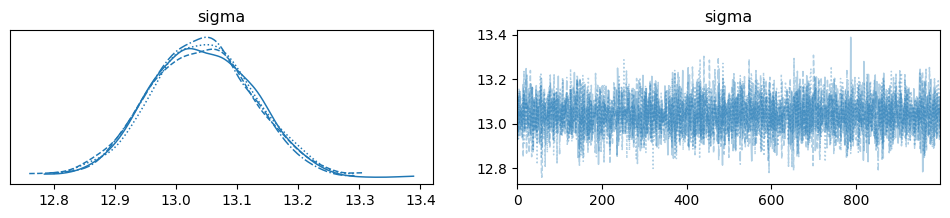

In [121]:
az.plot_trace(trace,  var_names = ["sigma"], divergences = True)

In [140]:
az.summary(trace.posterior.mu)

AttributeError: 'Dataset' object has no attribute 'mu'

In [131]:
with fda_model:
    trace_posterior = pm.sample_posterior_predictive(trace)

Sampling: [likelihood]


In [136]:
predicted_ci = az.summary(trace_posterior.posterior_predictive)[["hdi_3%", "hdi_97%", "mean"]]

ValueError: cannot reshape array of size 11684 into shape (2332,27)

### Results

In [123]:
position_1_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":1})["mean"].to_numpy()

In [124]:
position_2_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":2})["mean"].to_numpy()


In [125]:
position_0_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":0})["mean"].to_numpy()


In [126]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Age')

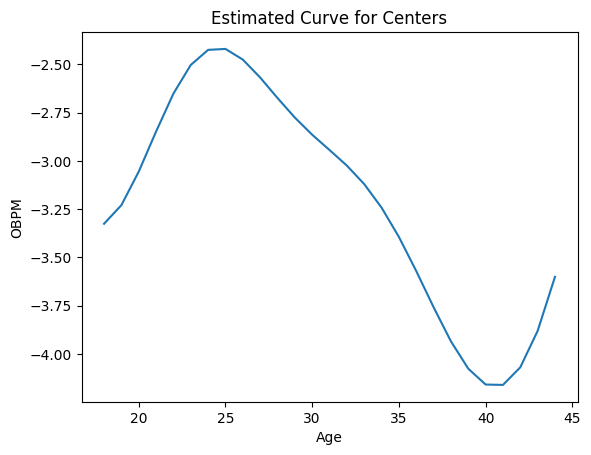

In [127]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Centers")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

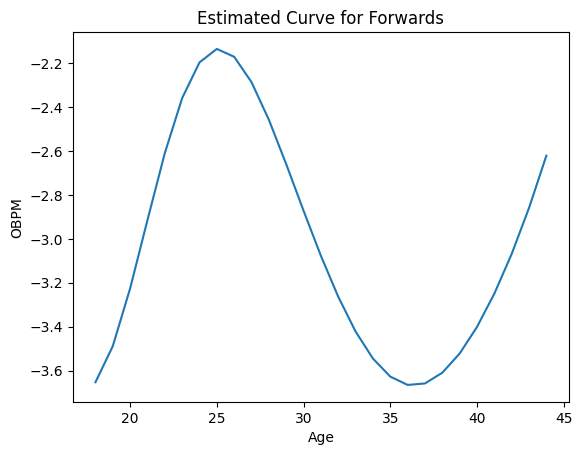

In [128]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_1_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Forwards")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

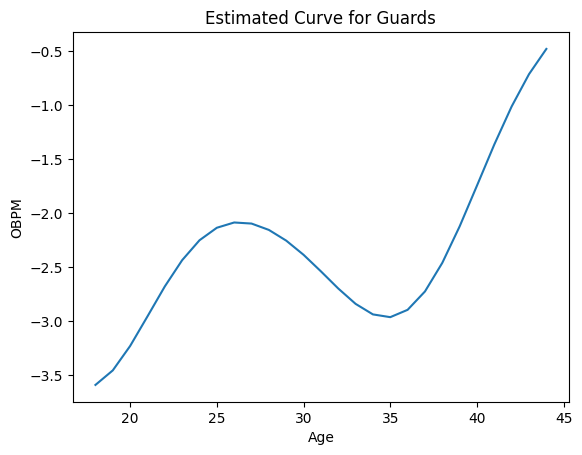

In [129]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_2_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Guards")
plt.ylabel("OBPM")
plt.xlabel("Age")

### Multivariate Analysis of Career Trajectory
Here, we will focus on the output where we have multiple trajectories. 


$$ y_1(t) = X\Phi_1(t) + \epsilon_1 $$
$$ \epsilon_1 \sim \mathcal{N}(0, \Sigma_1) $$


$$ y_2(t) = X\Phi_2(t) + \epsilon_2 $$
$$ \epsilon_2 \sim \mathcal{N}(0, \Sigma_2) $$

$$ \Phi(t) =  [\Phi_1(t),\Phi_2(t)]^{T}  \sim \mathcal{N}(0, \Omega)$$ 


where $\Phi(t)$ is a functional. Here, we let $X$ be fixed set of covariates (initially). We are also looking to model the correlation between the two functionals. 

#### Create Features

In [156]:
exposure_obpm, Y_obpm, X = process_data(data, "obpm", "median_minutes_per_game", "gaussian", ["position_group", "three_pct", "ft_pct", "two_pct"])
exposure_dbpm, Y_dbpm, X = process_data(data, "dbpm", "median_minutes_per_game", "gaussian", ["position_group","three_pct", "ft_pct", "two_pct"])

In [157]:
fixed_eff_matrix = np.insert(pd.get_dummies(X.fillna(0), drop_first=True,dtype=int).to_numpy(), 0 , 1, axis = 1)

In [38]:
basis = np.arange(18,45)
radial_basis_function = np.exp(-1/50*np.square(np.subtract.outer(basis,basis)))

### Build Model

In [158]:
mask = np.isfinite(exposure_obpm)
exposure_obpm[~mask] = -999
exposure_obpm = np.ma.masked_values(exposure_obpm.flatten(), value=-999)
Y_obpm[~mask] = -999
Y_obpm = np.ma.masked_values(Y_obpm.flatten(), value =-999)


mask = np.isfinite(exposure_dbpm)
exposure_dbpm[~mask] = -999
exposure_dbpm = np.ma.masked_values(exposure_dbpm.flatten(), value=-999)
Y_dbpm[~mask] = -999
Y_dbpm = np.ma.masked_values(Y_dbpm.flatten(), value =-999)

In [59]:
with pm.Model() as fda_model_multivariate:
    
    ### scaled variance
    variance_obpm = pm.MutableData("variance_obpm", exposure_obpm)
    variance_dbpm = pm.MutableData("variance_dbpm", exposure_dbpm)

    radial_basis = pm.MutableData("radial_basis", radial_basis_function) ### radial basis 

    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)

    ### prior on correlation
    chol, _, _ = pm.LKJCholeskyCov(
        "chol", n=2, eta=2.0, sd_dist=pm.Exponential.dist(1.0, shape=2)
    )

    basis_weights_raw = pm.Normal("basis_weights_raw", mu = 0, sigma = 1, shape = (2, fixed_eff_matrix.shape[1]*radial_basis_function.shape[0]))
    basis_weights = pm.Deterministic("basis_weights", chol.dot(basis_weights_raw))
    basis_weights_reshaped = pm.Deterministic("basis_weights_reshaped", basis_weights.reshape((fixed_eff_matrix.shape[1]*2,radial_basis_function.shape[0])))

    basis_weights_dbpm = pm.Deterministic("basis_weights_dbpm", basis_weights_reshaped[3::,:])
    basis_weights_obpm = pm.Deterministic("basis_weights_obpm", basis_weights_reshaped[0:3,:])
    mu_obpm = pm.math.dot(pm.math.dot(fixed_effects, basis_weights_obpm), radial_basis) ### get mu
    mu_dbpm = pm.math.dot(pm.math.dot(fixed_effects, basis_weights_dbpm), radial_basis) ### get mu
    ## likelihood
    sd_obpm = pm.Exponential("sigma_obpm", 1.0)
    y_obpm = pm.Normal("likelihood_obpm", pm.math.flatten(mu_obpm), sigma = sd_obpm / variance_obpm, observed=Y_obpm)

    sd_dbpm = pm.Exponential("sigma_dbpm", 1.0)
    y_dbpm = pm.Normal("likelihood_dbpm", pm.math.flatten(mu_dbpm), sigma = sd_dbpm / variance_dbpm, observed=Y_dbpm)

with fda_model_multivariate:
    trace = pm.sample()

/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/pymc/model/core.py:1365: ImputationWarning: Data in likelihood_obpm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/pymc/model/core.py:1365: ImputationWarning: Data in likelihood_dbpm contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol, basis_weights_raw, sigma_obpm, likelihood_obpm_unobserved, sigma_dbpm, likelihood_dbpm_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8412 seconds.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.


### Results


In [97]:
obpm_basis = az.summary(trace.posterior.basis_weights_obpm)["mean"].to_numpy().reshape((3,27))

In [91]:
dbpm_basis = az.summary(trace.posterior.basis_weights_dbpm)["mean"].to_numpy().reshape((3,27))

In [89]:
guards = np.array([[1,0,1]])
centers = np.array([[1,0,0]])
forwards = np.array([[1,1,0]])

Text(0.5, 0, 'Age')

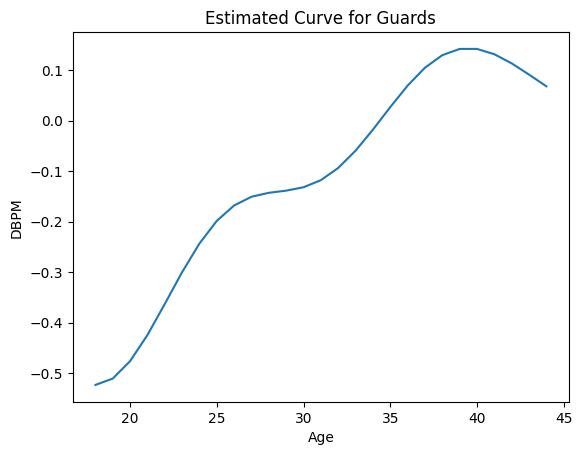

In [95]:
import matplotlib.pyplot as plt
plt.plot(range(18,45),guards.dot(dbpm_basis).dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Guards")
plt.ylabel("DBPM")
plt.xlabel("Age")


Text(0.5, 0, 'Age')

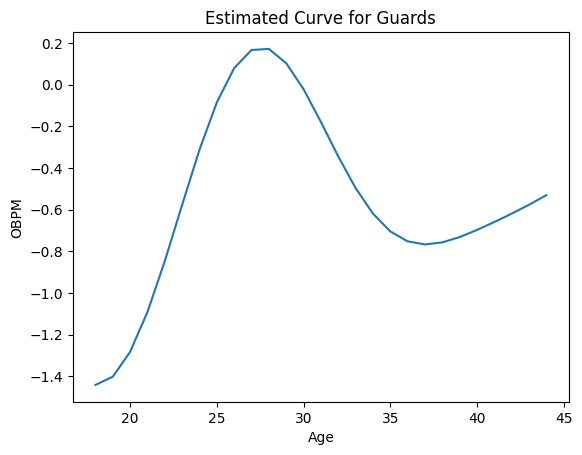

In [98]:
plt.plot(range(18,45),guards.dot(obpm_basis).dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Guards")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

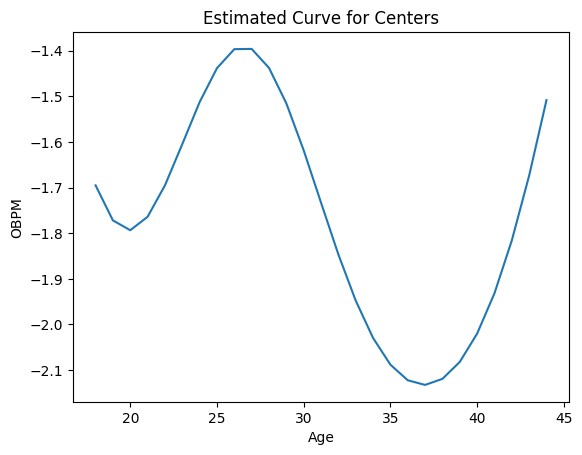

In [99]:
plt.plot(range(18,45),centers.dot(obpm_basis).dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Centers")
plt.ylabel("OBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

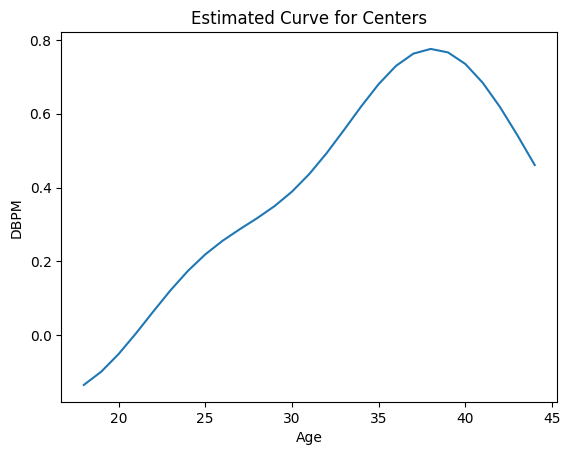

In [100]:
plt.plot(range(18,45),centers.dot(dbpm_basis).dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Centers")
plt.ylabel("DBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

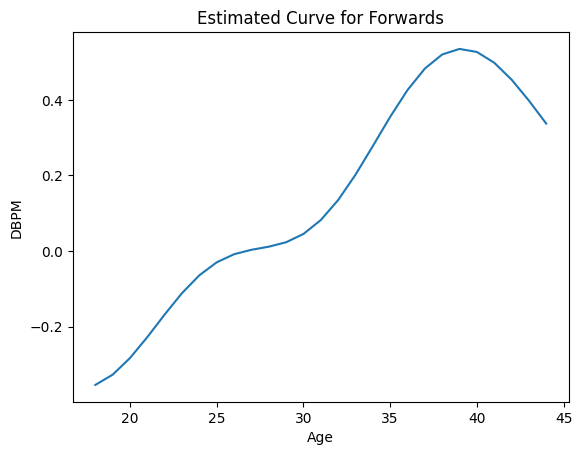

In [101]:
plt.plot(range(18,45),forwards.dot(dbpm_basis).dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Forwards")
plt.ylabel("DBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

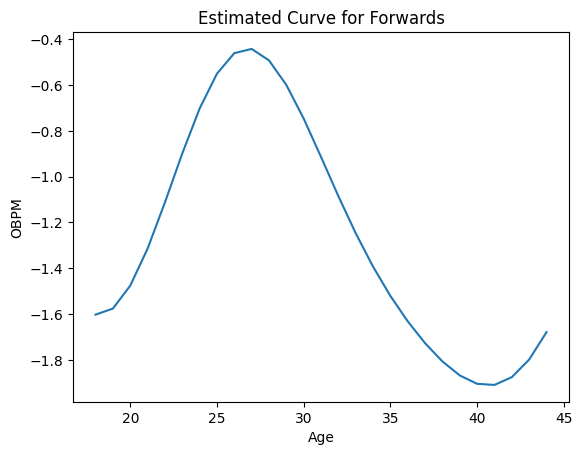

In [102]:
plt.plot(range(18,45),forwards.dot(obpm_basis).dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Forwards")
plt.ylabel("OBPM")
plt.xlabel("Age")

In [104]:
L.dot(L.T)

array([[ 0.234256, -0.005808],
       [-0.005808,  0.028033]])

In [105]:
-0.005808/(0.234256*0.028033)

-0.8844357874559293

### Just DBPM Separately
Use same as OBPM model, but model DBPM separately

In [159]:
with pm.Model() as fda_model:
    
    variance = pm.MutableData("variance", exposure_dbpm)
    radial_basis = pm.MutableData("radial_basis", radial_basis_function) ### radial basis 
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    basis_weights = pm.Normal("basis_weights", mu = 0, sigma = 1, shape = (fixed_eff_matrix.shape[1], radial_basis_function.shape[0]))
    mu = pm.math.dot(pm.math.dot(fixed_effects, basis_weights), radial_basis) ### get mu
    sd = pm.Exponential("sigma", 1.0)
    ## likelihood
    y = pm.Normal("likelihood", pm.math.flatten(mu), sigma = sd / variance_dbpm, observed=Y_dbpm)

with fda_model:
    trace = pm.sample()

/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/pymc/model/core.py:1365: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights, sigma, likelihood_unobserved]
Process worker_chain_1:
Process worker_chain_0:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/pymc/sampling/parallel.py", line 122, in run
    self._start_loop()
  File "/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/pymc/sampling/parallel.py", line 161, in _start_loo

KeyboardInterrupt: 

### Results

In [108]:
position_1_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":1})["mean"].to_numpy()

In [109]:
position_2_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":2})["mean"].to_numpy()


In [110]:
position_0_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":0})["mean"].to_numpy()


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Age')

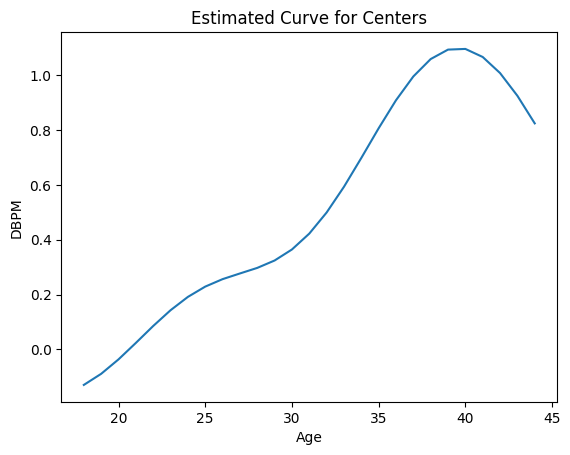

In [111]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Centers")
plt.ylabel("DBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

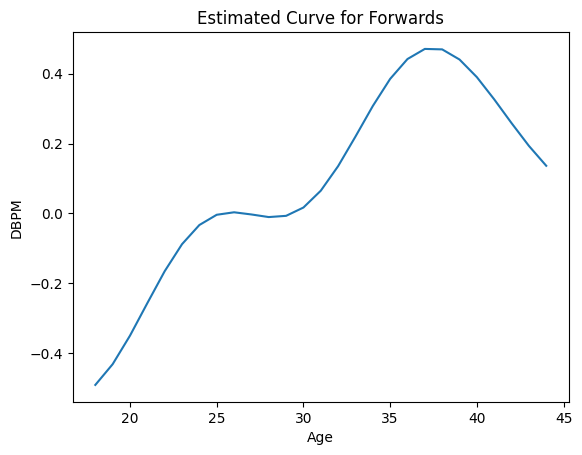

In [112]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_1_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Forwards")
plt.ylabel("DBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

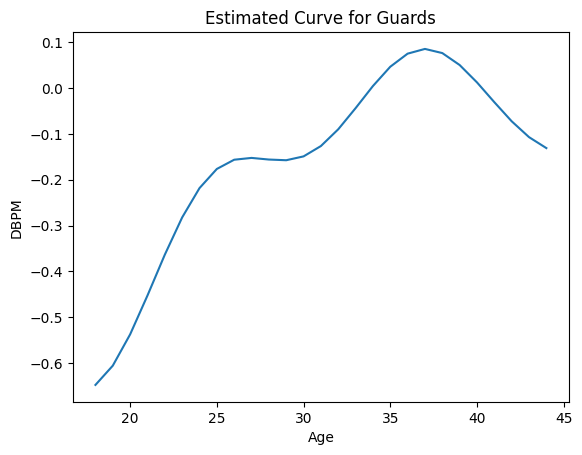

In [113]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_2_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Guards")
plt.ylabel("DBPM")
plt.xlabel("Age")

### Just DBPM w minutes
Use same as OBPM model, but model DBPM separately, this time with minutes as covariate

In [160]:
with pm.Model() as fda_model:
    
    variance = pm.MutableData("variance", exposure_dbpm)
    radial_basis = pm.MutableData("radial_basis", radial_basis_function) ### radial basis 
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    basis_weights = pm.Normal("basis_weights", mu = 0, sigma = 10, shape = (fixed_eff_matrix.shape[1], radial_basis_function.shape[0]))
    mu = pm.math.dot(pm.math.dot(fixed_effects, basis_weights), radial_basis) ### get mu
    sd = pm.Exponential("sigma", 1.0)
    ## likelihood
    y = pm.Normal("likelihood", pm.math.flatten(mu), sigma = sd / variance_dbpm, observed=Y_dbpm)

with fda_model:
    trace = pm.sample()

/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/pymc/model/core.py:1365: ImputationWarning: Data in likelihood contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights, sigma, likelihood_unobserved]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 33973 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [162]:
fixed_eff_matrix

array([[1.        , 0.38829787, 0.8410596 , 0.47120419, 0.        ,
        1.        ],
       [1.        , 0.36170213, 0.78297872, 0.46491228, 1.        ,
        0.        ],
       [1.        , 0.        , 0.80672269, 0.41778976, 1.        ,
        0.        ],
       ...,
       [1.        , 0.27118644, 0.67391304, 0.46938776, 0.        ,
        1.        ],
       [1.        , 0.        , 0.6969697 , 0.52380952, 1.        ,
        0.        ],
       [1.        , 0.13333333, 0.81818182, 0.57692308, 1.        ,
        0.        ]])

### Results

In [161]:
az.summary(trace.posterior.basis_weights)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"basis_weights[0, 0]",-0.122,6.965,-14.028,12.876,1.781,1.284,15.0,65.0,1.20
"basis_weights[0, 1]",1.762,8.542,-13.579,17.857,1.710,1.223,25.0,65.0,1.14
"basis_weights[0, 2]",0.880,8.136,-13.998,15.352,1.285,0.915,42.0,161.0,1.09
"basis_weights[0, 3]",0.098,9.294,-18.541,17.918,1.587,1.132,35.0,85.0,1.09
"basis_weights[0, 4]",-3.532,9.515,-19.114,15.264,3.375,2.480,8.0,39.0,1.45
...,...,...,...,...,...,...,...,...,...
"basis_weights[5, 22]",-0.553,8.144,-16.782,13.304,1.109,0.788,55.0,54.0,1.07
"basis_weights[5, 23]",-3.004,9.095,-18.219,14.798,2.302,1.659,15.0,85.0,1.21
"basis_weights[5, 24]",-2.588,8.567,-17.430,12.859,1.570,1.121,31.0,111.0,1.13
"basis_weights[5, 25]",2.753,8.389,-13.284,16.682,2.178,1.571,15.0,89.0,1.21


In [127]:
position_2_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":3})["mean"].to_numpy()


In [128]:
position_0_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":0})["mean"].to_numpy()


In [ ]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Age')

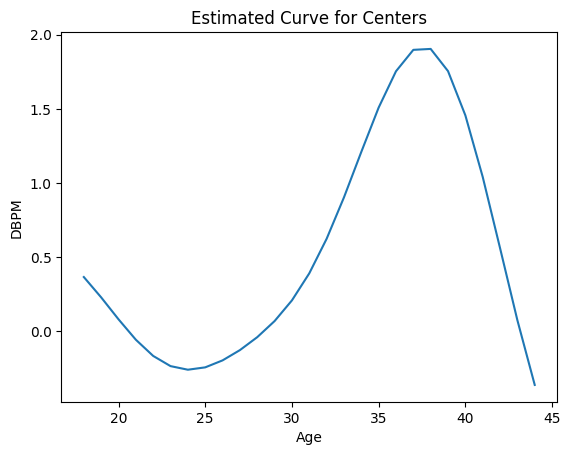

In [129]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:] )
plt.title("Estimated Curve for Centers")
plt.ylabel("DBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

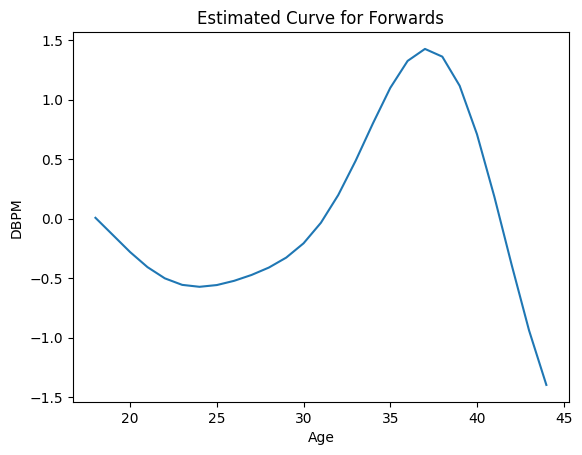

In [130]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_1_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Forwards")
plt.ylabel("DBPM")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

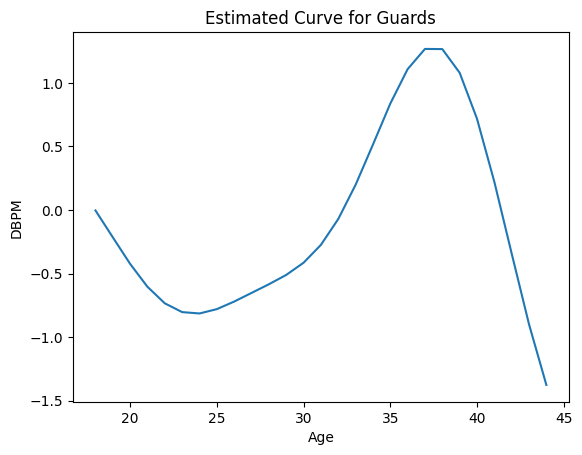

In [131]:
plt.plot(range(18,45), position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_2_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])
plt.title("Estimated Curve for Guards")
plt.ylabel("DBPM")
plt.xlabel("Age")

<Axes: xlabel='age'>

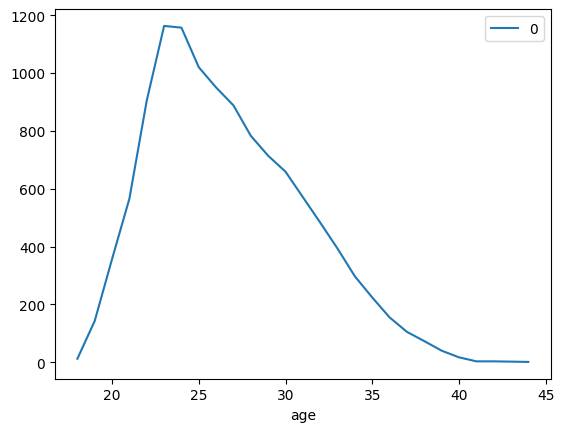

In [145]:
data.groupby("age").apply(lambda x: len(x)).reset_index().plot.line(x = "age")

### Use Non Gaussian Metric
Here, I will use something like FG 3 PCT

In [143]:
exposure, Y, X = process_data(data, "fg3m", "fg3a", "binomial", ["position_group"])

In [14]:
Y

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [144]:
fixed_eff_matrix = np.insert(pd.get_dummies(X, drop_first=True,dtype=int).to_numpy(), 0 , 1, axis = 1)

array([0, 3, 3, ..., 0, 1, 0])

In [145]:
mask = np.isfinite(exposure)



In [146]:
with pm.Model() as fda_model:
    
    trials = pm.MutableData("variance", exposure[mask].flatten())
    radial_basis = pm.MutableData("radial_basis", radial_basis_function) ### radial basis 
    fixed_effects = pm.MutableData("X", fixed_eff_matrix) ### X data (latent space)
    basis_weights = pm.Normal("basis_weights", mu = 0, sigma = 1, shape = (fixed_eff_matrix.shape[1], radial_basis_function.shape[0]))
    mu = pm.math.dot(pm.math.dot(fixed_effects, basis_weights), radial_basis) ### get mu
    ## likelihood
    y = pm.Binomial("likelihood", logit_p = pm.math.flatten(mu[mask]), n = trials, observed=Y[mask].flatten())

with fda_model:
    trace = pm.sample()


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [basis_weights]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7139 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [147]:
az.summary(trace.posterior.basis_weights)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"basis_weights[0, 0]",-1.201,0.636,-2.313,0.022,0.062,0.047,106.0,206.0,1.05
"basis_weights[0, 1]",-0.382,0.841,-2.010,1.118,0.077,0.055,119.0,280.0,1.03
"basis_weights[0, 2]",0.252,0.806,-1.233,1.739,0.057,0.041,199.0,351.0,1.02
"basis_weights[0, 3]",0.607,0.864,-1.016,2.216,0.055,0.039,246.0,501.0,1.01
"basis_weights[0, 4]",0.371,0.855,-1.178,2.084,0.059,0.041,214.0,535.0,1.01
...,...,...,...,...,...,...,...,...,...
"basis_weights[2, 22]",0.177,0.885,-1.537,1.815,0.054,0.038,266.0,515.0,1.01
"basis_weights[2, 23]",0.138,0.911,-1.521,1.820,0.053,0.038,300.0,652.0,1.00
"basis_weights[2, 24]",0.083,0.893,-1.607,1.766,0.049,0.035,332.0,649.0,1.01
"basis_weights[2, 25]",-0.063,0.870,-1.724,1.614,0.057,0.040,233.0,433.0,1.02


/Users/abhijitbrahme/Library/Caches/pypoetry/virtualenvs/nba-functional-analysis-6oEKqHGM-py3.9/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


array([[<Axes: ylabel='basis_weights\n0, 1'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 2'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 3'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 4'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 5'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 6'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='basis_weights\n0, 7'>, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='basis_weights\n0, 0', ylabel='basis_weights\n0, 8'>,
        <Axes: xlabel='basis_weights\n0, 1'>,
   

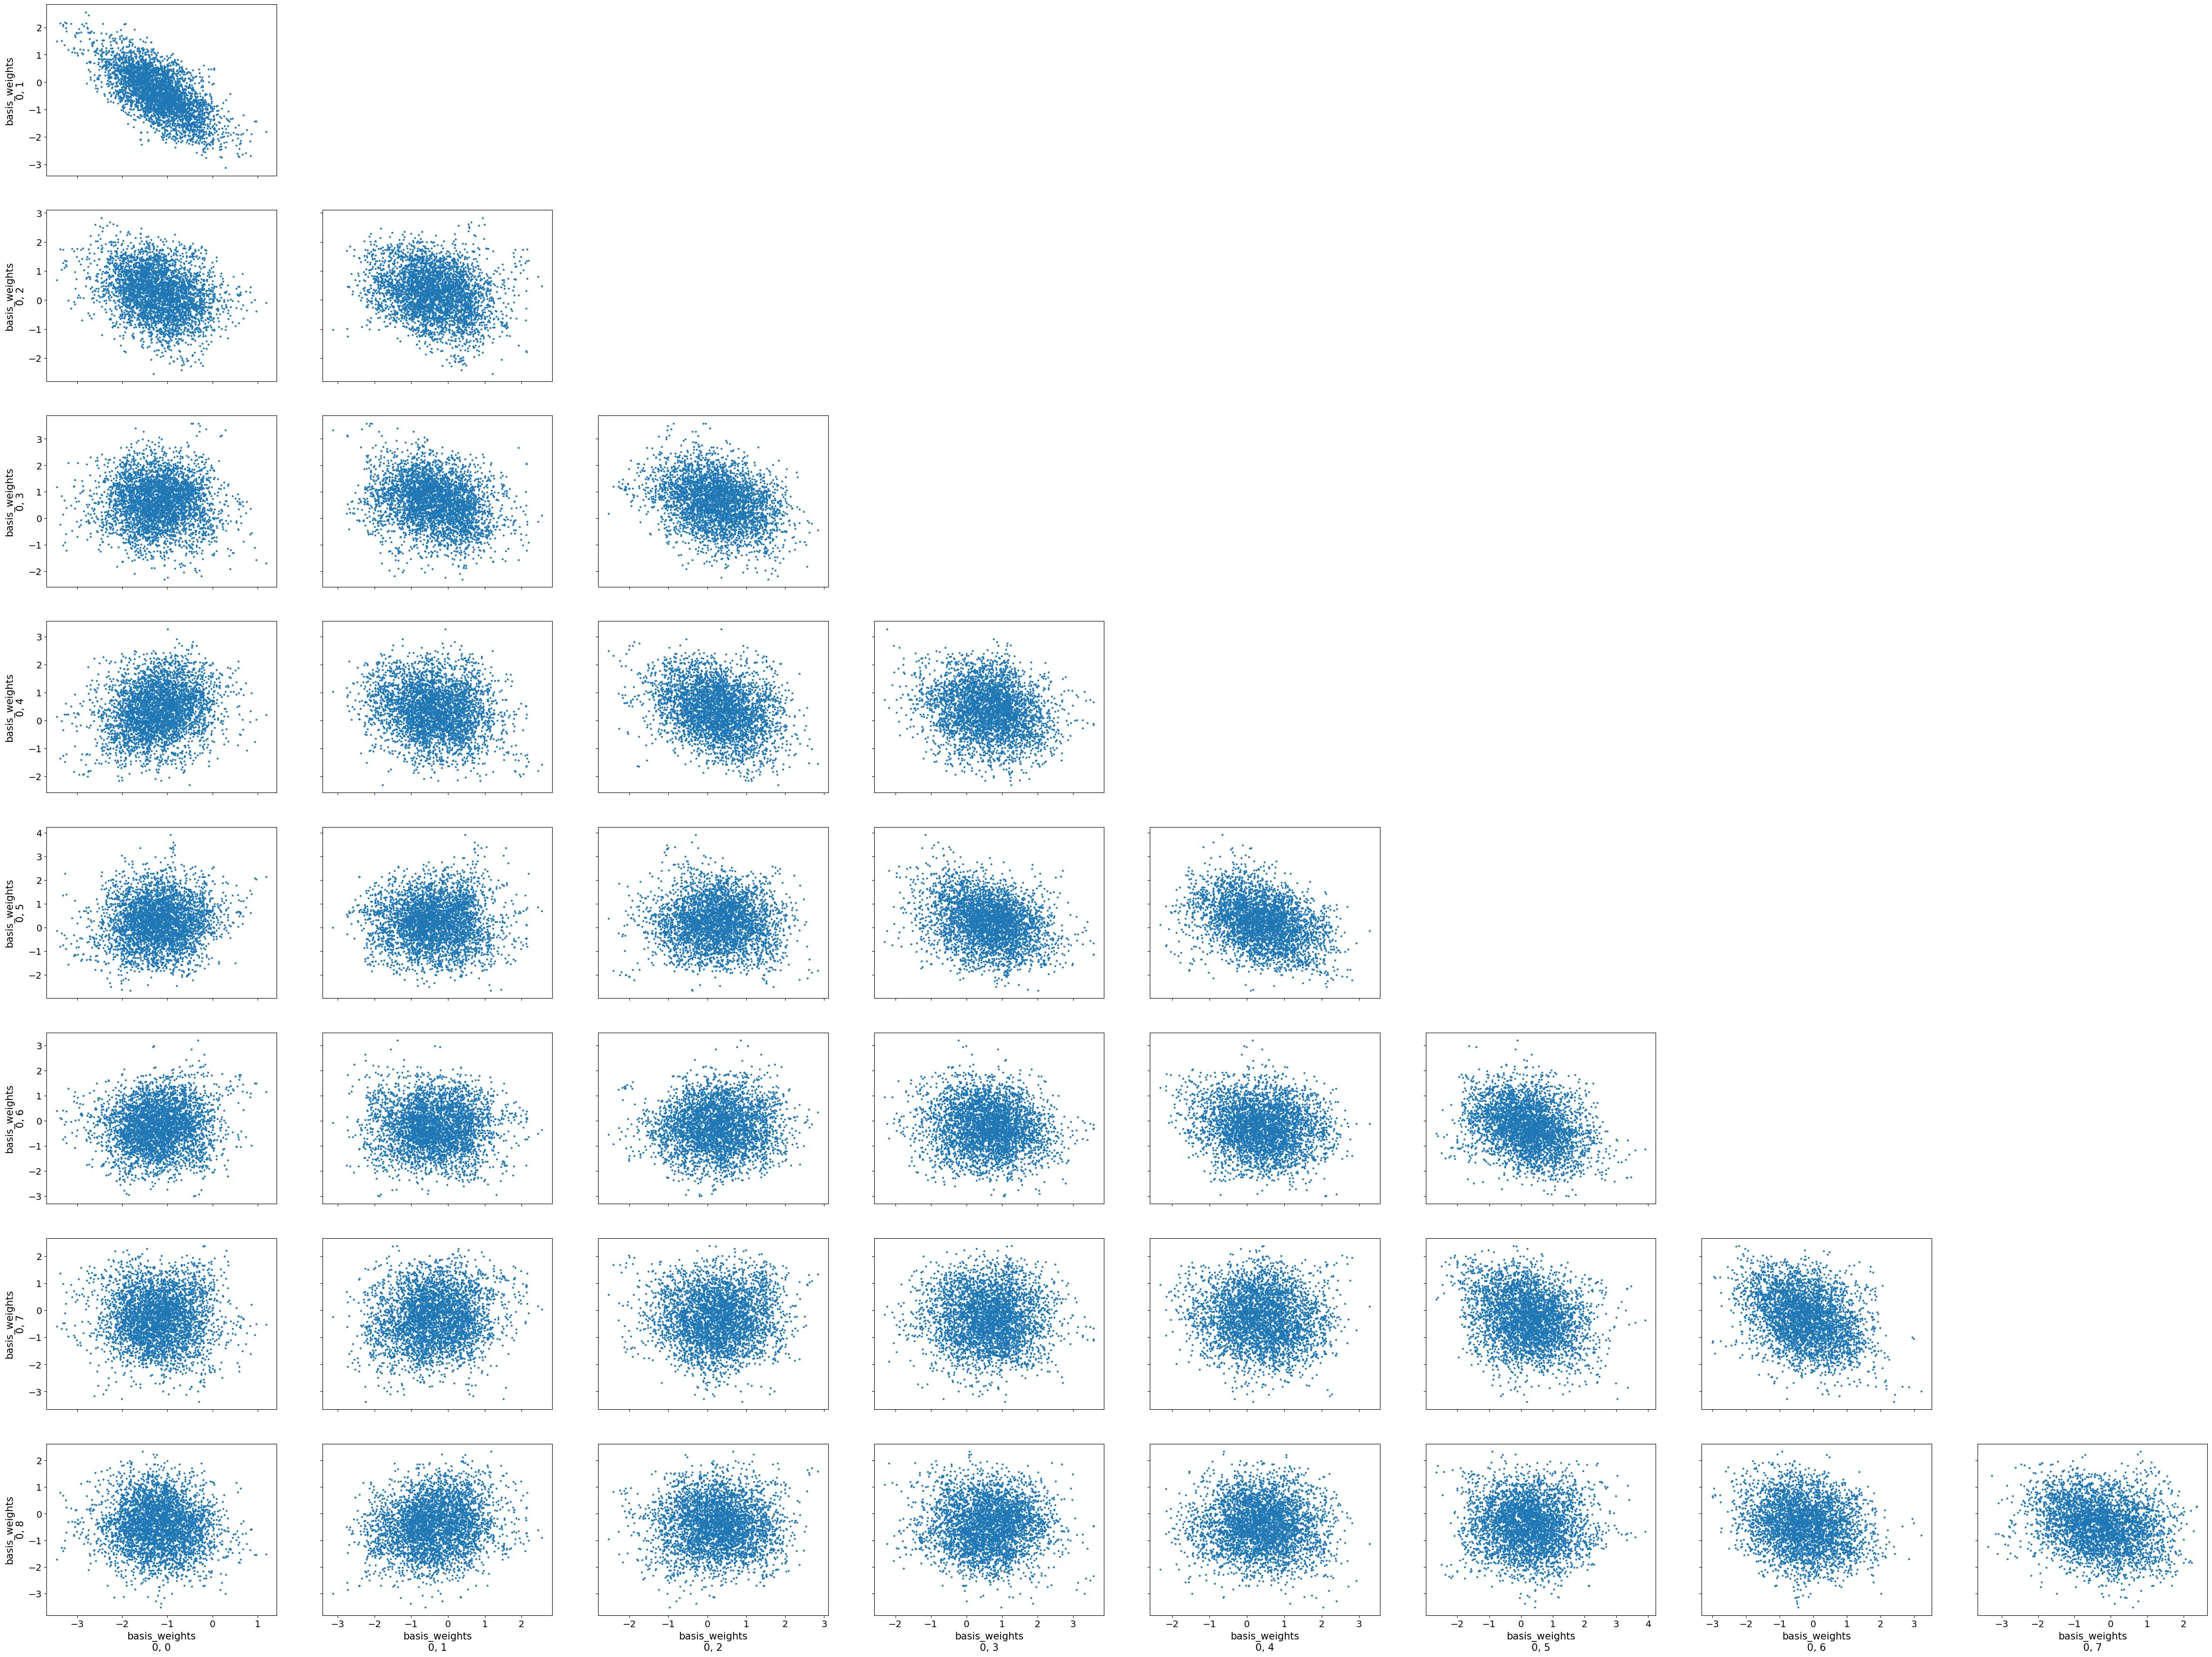

In [148]:
az.plot_pair(trace, var_names="basis_weights", divergences=True)

In [149]:
position_2_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":2})["mean"].to_numpy()


In [150]:
position_0_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":0})["mean"].to_numpy()


In [151]:
position_1_weights = az.summary(trace.posterior.basis_weights, coords={"basis_weights_dim_0":1})["mean"].to_numpy()


In [152]:
from scipy.special import expit

Text(0.5, 0, 'Age')

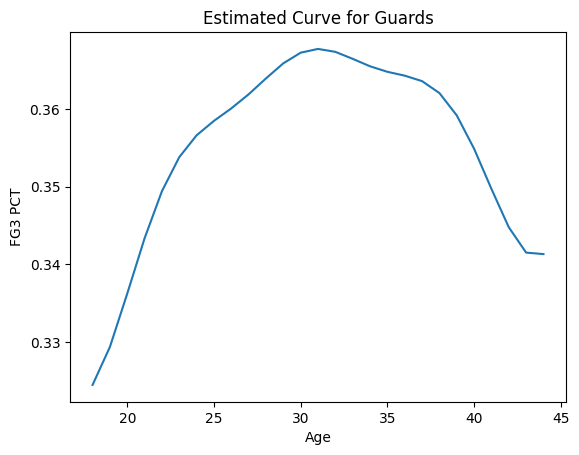

In [153]:
plt.plot(range(18,45), expit(position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_2_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]))
plt.title("Estimated Curve for Guards")
plt.ylabel("FG3 PCT")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

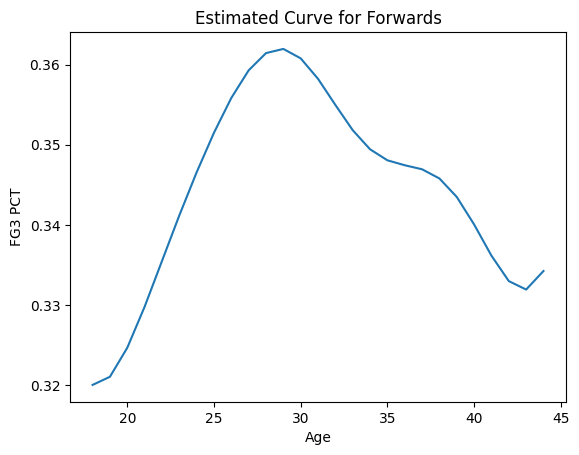

In [154]:
plt.plot(range(18,45), expit(position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]  + position_1_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:]))
plt.title("Estimated Curve for Forwards")
plt.ylabel("FG3 PCT")
plt.xlabel("Age")

Text(0.5, 0, 'Age')

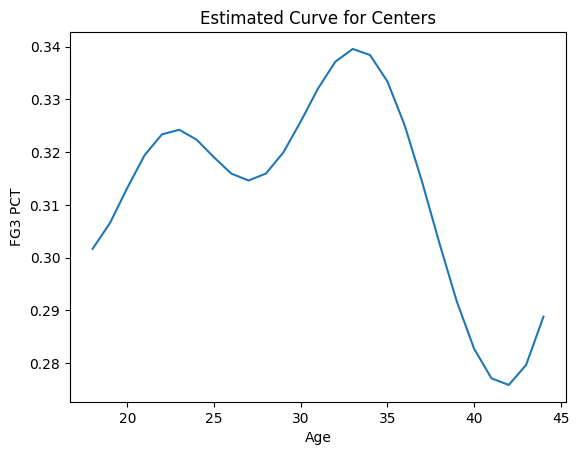

In [155]:
plt.plot(range(18,45), expit(position_0_weights[:,np.newaxis].T.dot(radial_basis_function)[0,:])  )
plt.title("Estimated Curve for Centers")
plt.ylabel("FG3 PCT")
plt.xlabel("Age")

array([[<Axes: ylabel='basis_weights\n1'>, <Axes: >],
       [<Axes: xlabel='basis_weights\n0', ylabel='basis_weights\n2'>,
        <Axes: xlabel='basis_weights\n1'>]], dtype=object)

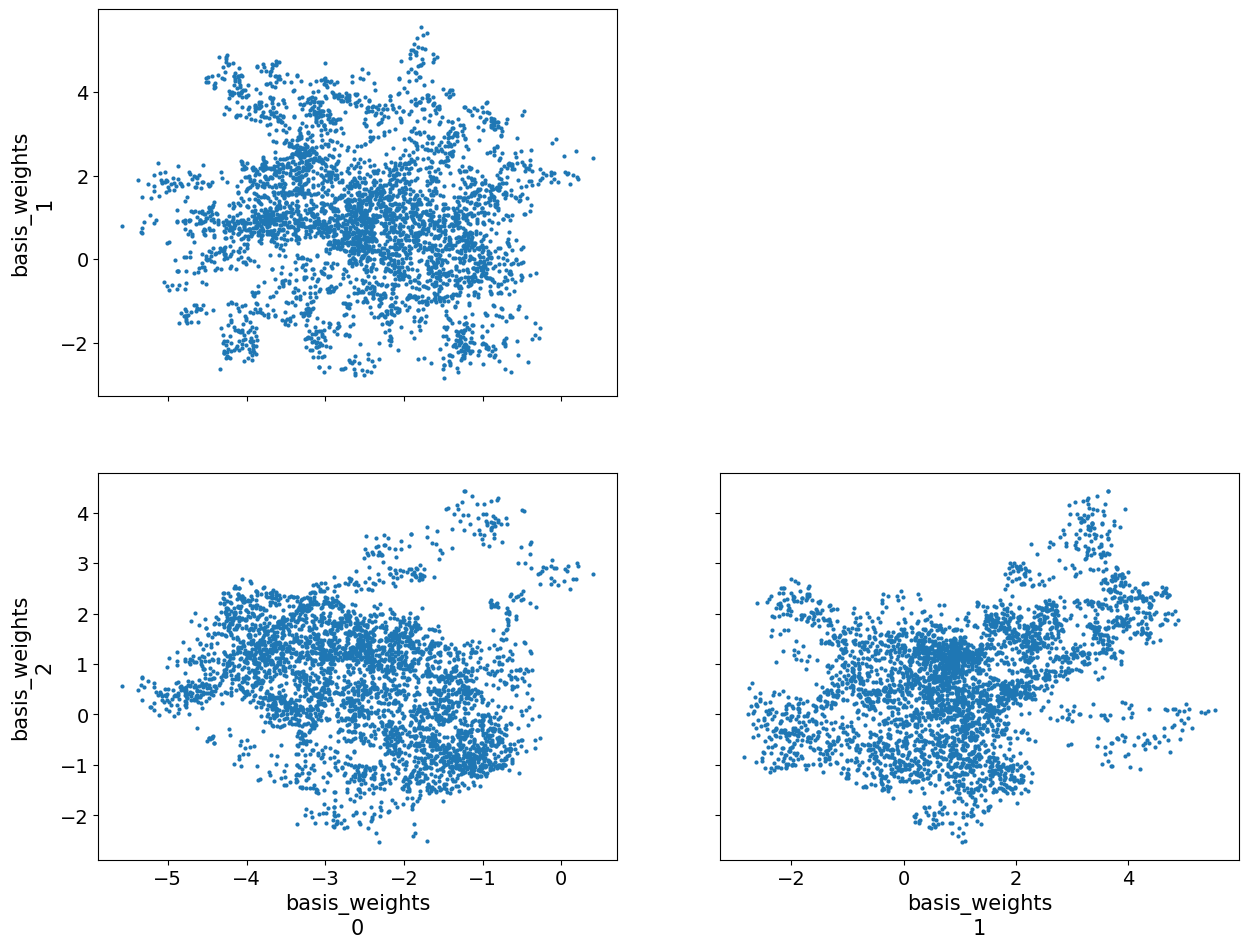

In [49]:
az.plot_pair(trace,  var_names = ["basis_weights"], coords= {"basis_weights_dim_1": 0}, divergences = True)